In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
import nltk

# Download VADER lexicon if not already available
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

# --- Function to search Reddit using the public JSON API ---
def search_reddit_web(query, subreddit="Thunder", limit=300):
    headers = {"User-Agent": "Mozilla/5.0"}
    url = "https://www.reddit.com/search.json"
    params = {
        "q": f"{query} subreddit:{subreddit}",
        "sort": "new",
        "limit": limit,
        "restrict_sr": "on"
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        print(f"Request failed: Status Code {response.status_code}")
        return pd.DataFrame()
    children = response.json().get("data", {}).get("children", [])
    posts = [{
        "title": c["data"].get("title", ""),
        "text": c["data"].get("selftext", ""),
        "created_utc": c["data"].get("created_utc", None)
    } for c in children]
    return pd.DataFrame(posts)

# --- Define Playoffs cutoff date ---
playoffs_date = datetime(2025, 4, 7)

# --- Fetch Reddit posts ---
df = search_reddit_web('"Ajay Mitchell"', limit=300)

if not df.empty:
    # Combine title and text, and convert timestamp
    df["text_combined"] = df["title"] + " " + df["text"].fillna("")
    df["vader_sentiment"] = df["text_combined"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
    df["post_date"] = df["created_utc"].apply(lambda x: datetime.fromtimestamp(x) if pd.notnull(x) else None)

    # Separate by Finals date
    before_df = df[df["post_date"] < playoffs_date].copy()
    after_df = df[df["post_date"] >= playoffs_date].copy()

    # --- Summary Metrics ---
    def summarize(name, df):
        if df.empty:
            print(f"\n📅 {name.upper()} — No posts found.")
            return
        start = df["post_date"].min().strftime("%Y-%m-%d")
        end = df["post_date"].max().strftime("%Y-%m-%d")
        days = (df["post_date"].max() - df["post_date"].min()).days + 1
        avg_per_day = len(df) / days if days > 0 else 0
        sentiment_avg = df["vader_sentiment"].mean()
        print(f"\n📅 {name.upper()} POST DATE RANGE:")
        print(f"- From: {start}")
        print(f"- To  : {end}")
        print(f"- Duration: {days} days")
        print(f"- Posts scraped: {len(df)}")
        print(f"- Avg posts per day: {avg_per_day:.2f}")
        print(f"- Avg VADER sentiment: {sentiment_avg:.3f}")

    summarize("Before Finals", before_df)
    summarize("After Finals", after_df)

else:
    print("No posts found.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sudarshanraj/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



📅 BEFORE FINALS POST DATE RANGE:
- From: 2025-02-21
- To  : 2025-04-06
- Duration: 45 days
- Posts scraped: 31
- Avg posts per day: 0.69
- Avg VADER sentiment: -0.136

📅 AFTER FINALS POST DATE RANGE:
- From: 2025-04-07
- To  : 2025-07-08
- Duration: 93 days
- Posts scraped: 69
- Avg posts per day: 0.74
- Avg VADER sentiment: 0.253


This chart breaks down sentiment by category — Positive, Neutral, and Negative — based on VADER thresholds. Reddit discourse surrounding Oklahoma City Thunder guard Ajay Mitchell became markedly more positive following the 2025 NBA Playoffs, according to a VADER sentiment analysis of posts on r/Thunder. Before the Playoffs from post recorded from February 2nd to April 7th, negative and neutral posts dominated, while positive sentiment was relatively sparse. After April 7th, which was the day Mitchell retunred from injury in preparation for the playoffs, the distribution shifted toward a much higher share of positive posts, reflecting a clear tonal improvement. This transition helps substantiate the broader narrative that Mitchell's postseason involvement or public image helped reshape his standing among the fanbase.

In [3]:
import matplotlib as mpl

# Match R's default font (especially on macOS)
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['font.size'] = 11  # matches ggplot2's default text size


In [4]:
def summarize(name, df):
    if df.empty:
        print(f"\n{name.upper()} — No posts found.")
        return
    start = df["post_date"].min().strftime("%Y-%m-%d")
    end = df["post_date"].max().strftime("%Y-%m-%d")
    days = (df["post_date"].max() - df["post_date"].min()).days + 1
    avg_per_day = len(df) / days if days > 0 else 0
    print(f"\n📅 {name} Post Date Range:")
    print(f"- From: {start}")
    print(f"- To  : {end}")
    print(f"- Duration: {days} days")
    print(f"- Total Posts: {len(df)}")
    print(f"- Avg Posts Per Day: {avg_per_day:.2f}")

summarize("Before Playoffs", before_df)
summarize("After Playoffs", after_df)



📅 Before Playoffs Post Date Range:
- From: 2025-02-21
- To  : 2025-04-06
- Duration: 45 days
- Total Posts: 31
- Avg Posts Per Day: 0.69

📅 After Playoffs Post Date Range:
- From: 2025-04-07
- To  : 2025-07-08
- Duration: 93 days
- Total Posts: 69
- Avg Posts Per Day: 0.74


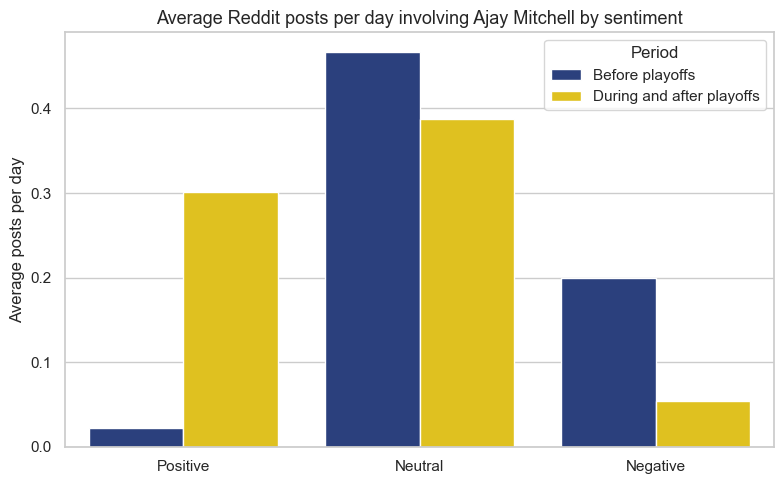

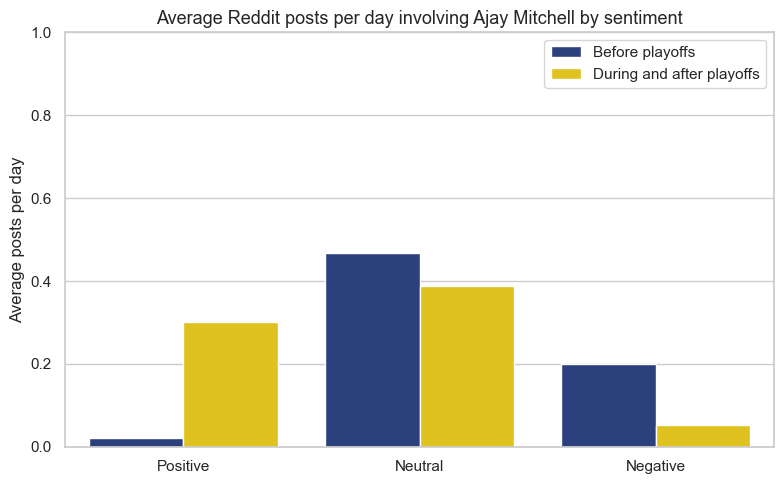

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Classify sentiment ---
def classify_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

before_df["sentiment"] = before_df["vader_sentiment"].apply(classify_sentiment)
after_df["sentiment"] = after_df["vader_sentiment"].apply(classify_sentiment)

# --- Calculate durations ---
days_before = (before_df["post_date"].max() - before_df["post_date"].min()).days + 1
days_after = (after_df["post_date"].max() - after_df["post_date"].min()).days + 1

# --- Posts per day by sentiment ---
def compute_posts_per_day(df, total_days, label):
    counts = df["sentiment"].value_counts().to_dict()
    return pd.DataFrame({
        "Sentiment": ["Positive", "Neutral", "Negative"],
        "Posts_per_day": [counts.get("Positive", 0) / total_days,
                          counts.get("Neutral", 0) / total_days,
                          counts.get("Negative", 0) / total_days],
        "Period": label
    })

before_stats = compute_posts_per_day(before_df, days_before, "Before playoffs")
after_stats = compute_posts_per_day(after_df, days_after, "During and after playoffs")

posts_df = pd.concat([before_stats, after_stats])

# --- Chart 1: Posts per Day ---
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=posts_df, x="Sentiment", y="Posts_per_day", hue="Period", palette=["#1E3A8A", "#FFD700"])
plt.title("Average Reddit posts per day involving Ajay Mitchell by sentiment", fontsize=13)
plt.ylabel("Average posts per day")
plt.xlabel("")
plt.tight_layout()
plt.show()

# --- Chart 2: Average Sentiment Score ---
avg_scores = pd.DataFrame({
    "Period": ["Before playoffs", "During and after playoffs"],
    "Avg_Sentiment": [before_df["vader_sentiment"].mean(), after_df["vader_sentiment"].mean()]
})

import matplotlib.patches as patches

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=posts_df,
    x="Sentiment",
    y="Posts_per_day",
    hue="Period",
    palette=["#1E3A8A", "#FFD700"]
)

# Add invisible patch to force y-limit to 1
ax.add_patch(
    patches.Rectangle(
        (-0.5, 0.95),  # start slightly left of first bar
        width=3,       # cover full bar span
        height=0.05,
        alpha=0
    )
)

ax.set_title("Average Reddit posts per day involving Ajay Mitchell by sentiment", fontsize=13)
ax.set_ylabel("Average posts per day")
ax.set_xlabel("")
ax.set_ylim(0, 1)

# ✅ Move legend to upper right
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()




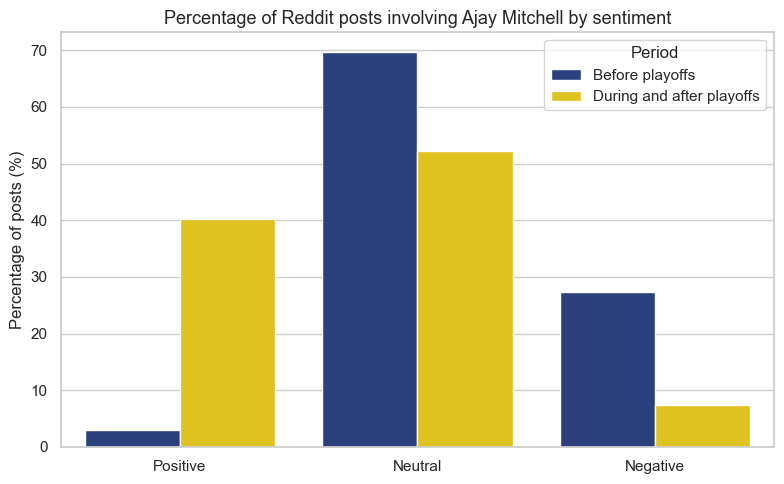

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Classify sentiment ---
def classify_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

before_df["sentiment"] = before_df["vader_sentiment"].apply(classify_sentiment)
after_df["sentiment"] = after_df["vader_sentiment"].apply(classify_sentiment)

# --- Function to compute sentiment percentages ---
def compute_percentage(df, label):
    total = len(df)
    counts = df["sentiment"].value_counts().to_dict()
    return pd.DataFrame({
        "Sentiment": ["Positive", "Neutral", "Negative"],
        "Percentage": [
            (counts.get("Positive", 0) / total) * 100,
            (counts.get("Neutral", 0) / total) * 100,
            (counts.get("Negative", 0) / total) * 100
        ],
        "Period": label
    })

# --- Generate dataframes ---
before_stats_pct = compute_percentage(before_df, "Before playoffs")
after_stats_pct = compute_percentage(after_df, "During and after playoffs")

posts_pct_df = pd.concat([before_stats_pct, after_stats_pct])

# --- Bar Chart: Percentage of Posts by Sentiment ---
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=posts_pct_df, x="Sentiment", y="Percentage", hue="Period", palette=["#1E3A8A", "#FFD700"])
plt.title("Percentage of Reddit posts involving Ajay Mitchell by sentiment", fontsize=13)
plt.ylabel("Percentage of posts (%)")
plt.xlabel("")
plt.tight_layout()
plt.show()
